# Evaluation Task

## Import Extracted Data

In [1]:
import os
save_dir = "FinalPlots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

dataset_path = "/home/jason/AutoEncoder/extracted_input.csv"

dataset = pd.read_csv(dataset_path)

In [3]:
dataset.head()

,E,pt,eta,phi
0,258722.0,243675.0,0.328962,2.25014
1,520092.0,108590.0,-2.247300,-1.85679
2,383024.0,88405.6,2.145160,-1.95635
3,39507.6,35365.1,0.470460,-1.16445
4,225430.0,26878.2,-2.816080,-2.25938


## Split Data
Train and test set are obtained from the dataset in a ratio of 80:20

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset.copy(), test_size=0.2)
# dataset[:18000].copy(), dataset[18000:].copy(), dataset[:18000].copy(), dataset[18000:].copy()

# indices are reset so that reassigning values of boxcox transformation works
index = pd.Series([i for i in range(0, len(test))])
test = test.set_index(index)

index = pd.Series([i for i in range(0, len(train))])
train = train.set_index(index)

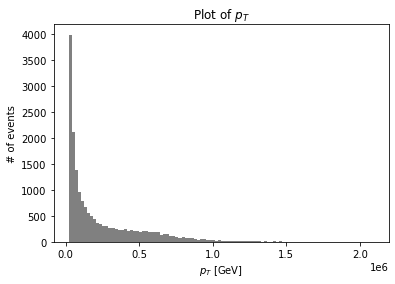

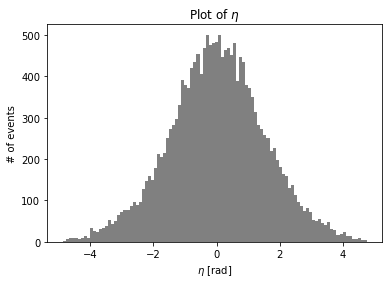

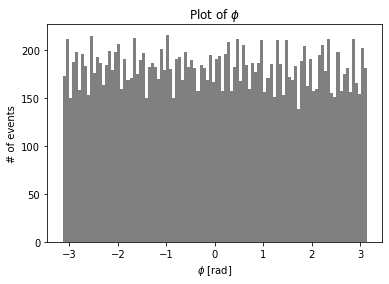

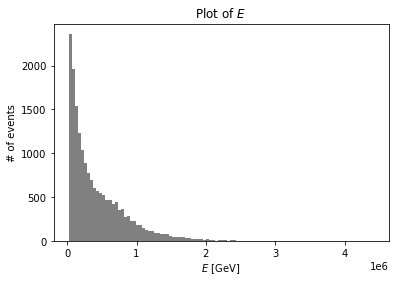

In [5]:
import matplotlib.pyplot as plt

unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title("Plot of " + variable_list[kk])
    plt.savefig(os.path.join(save_dir, "UnNormalised_"+branches[kk]),dpi=300)
    plt.show()

## Custom Normalisation
We normalise the data and I noticed boxcox seems to work better than log10 for "E" and "pt"

In [6]:

train["eta"] = train["eta"]/5
train["phi"] = train["phi"]/3

test["eta"] = test["eta"]/5
test["phi"] = test["phi"]/3


# train["E"] = np.log10(train["E"]/1000)
# train["pt"] = np.log10(train["pt"]/1000)
# # print(stats.shapiro(train["E"]))
# # print(stats.shapiro(train["pt"]))

# test["E"] = np.log10(test["E"]/1000)
# test["pt"] = np.log10(test["pt"]/1000)
# dataset["pt"] = np.sqrt(dataset["pt"])
# dataset["E"] = np.cbrt(dataset["E"])

# dataset["pt"] = np.log10(1+dataset["pt"])
# dataset["E"] = np.log10(1+dataset["E"])

# since data is right skewed, boxcox transformation works best
# we first apply the transformation to the train and then apply it to the
#    test dataset so that we dont leak information about the test data
a, maxlog1 = stats.boxcox(train["pt"].to_numpy())
b, maxlog2 = stats.boxcox(train["E"].to_numpy())

b = b/10
mean1 = a.mean()
mean2 = b.mean()

train["pt"] = pd.DataFrame(a-mean1)
train["E"] = pd.DataFrame(b-mean2)

a = stats.boxcox(test["pt"].to_numpy(), maxlog1)
b = stats.boxcox(test["E"].to_numpy(), maxlog2)/10
    
test["pt"] = pd.DataFrame(a-mean1)
test["E"] = pd.DataFrame(b-mean2)

    
train.head()

,E,pt,eta,phi
0,-0.077135,0.103361,-0.146949,-0.855403
1,-0.389686,-0.337067,-0.254600,0.237312
2,0.375389,0.506016,-0.070780,0.192229
3,0.391664,0.392475,-0.225546,-0.551460
4,0.086823,0.103073,-0.271984,-0.713147


## Plotting Normalised data

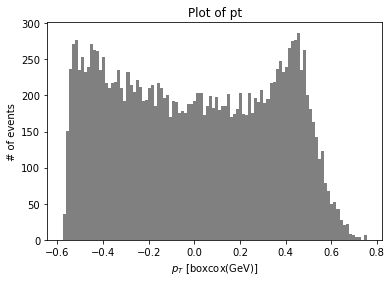

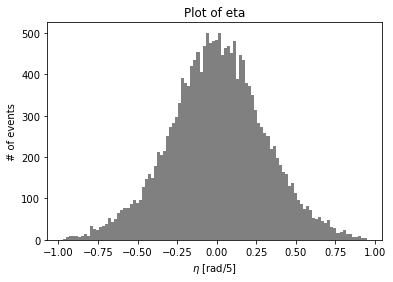

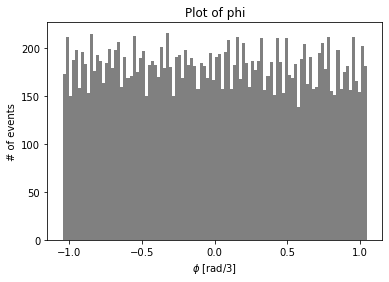

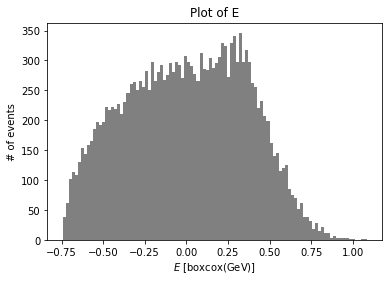

In [7]:
import matplotlib.pyplot as plt

#train = custom_unnormalize(train)
unit_list = ['[boxcox(GeV)]', '[rad/5]', '[rad/3]', '[boxcox(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title("Plot of " + branches[kk])
    plt.savefig(os.path.join(save_dir, "Normalised_"+branches[kk]),dpi=300)
    plt.show()

## Loading data into Pytorch Dataloader

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

# creating a copy of the data for X and y
# X and y are the same since the model is an autoencoder
X_test, y_test = test.copy(), test.copy()
X_train, y_train = train.copy(), train.copy()

print(train)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(X_test.values, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float))

              E        pt       eta       phi
0     -0.077135  0.103361 -0.146949 -0.855403
1     -0.389686 -0.337067 -0.254600  0.237312
2      0.375389  0.506016 -0.070780  0.192229
3      0.391664  0.392475 -0.225546 -0.551460
4      0.086823  0.103073 -0.271984 -0.713147
...         ...       ...       ...       ...
18123 -0.297255 -0.110200  0.144778  0.871910
18124 -0.543343 -0.421193 -0.184178 -0.102747
18125  0.227946  0.416815  0.024443 -0.468973
18126 -0.175896  0.085045 -0.006091 -0.479207
18127 -0.308930 -0.085433  0.111569  0.108739

[18128 rows x 4 columns]


/home/jason/miniconda3/envs/AE-compression/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:

bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## Creating a Tanh model with Batch Normalisation after each layer
It was seen that Tanh varient with a low MSE and low mean residual reconstruction error

In [10]:

class AE_3D_200_Tanh(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_Tanh, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.ebn1 = nn.BatchNorm1d(200)
        self.en2 = nn.Linear(200, 100)
        self.ebn2 = nn.BatchNorm1d(100)
        self.en3 = nn.Linear(100, 50)
        self.ebn3 = nn.BatchNorm1d(50)
        self.en4 = nn.Linear(50, 3)
        self.dbn0 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 50)
        self.dbn1 = nn.BatchNorm1d(50)
        self.de2 = nn.Linear(50, 100)
        self.dbn2 = nn.BatchNorm1d(100)
        self.de3 = nn.Linear(100, 200)
        self.dbn3 = nn.BatchNorm1d(200)
        self.de4 = nn.Linear(200, n_features)
        self.ELU = nn.SELU()

    def encode(self, x):
        x = self.en1(x)
        x = self.ELU(x)
        #x = self.ebn1(x)
        x = self.en2(x)
        x = self.ELU(x)
        #x = self.ebn2(x)
        x = self.en3(x)
        x = self.ELU(x)
        #x = self.ebn3(x)
        return self.en4(x)

    def decode(self, x):
        x = self.ELU(x)
        #x = self.dbn0(x)
        x = self.de1(x)
        x = self.ELU(x)
        #x = self.dbn1(x)
        x = self.de2(x)
        x = self.ELU(x)
        #x = self.dbn2(x)
        x = self.de3(x)
        x = self.ELU(x)
        #x = self.dbn3(x)
        return self.de4(x)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01) 
    
model = AE_3D_200_Tanh()
model.to('cpu')
#model.apply(init_weights)

AE_3D_200_Tanh(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (ebn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (ebn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (ebn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (dbn0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (dbn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (dbn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (dbn3): BatchNor

In [11]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## 1cycle training
The 1cycle policy allows to us train the model very quickly, a phenomenon termed superconvergence.

Learning rate with the minimum loss: 0.001096478197723627
Learning rate with the steepest gradient: 0.001737800776027143


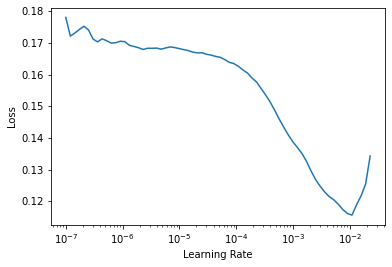

In [12]:
from fastai.callback import schedule

# to use 1cycle callback from fastai we need to find the optimum learning rate which we can find using lr_finder()
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [13]:
import time

# we find the time needed for training
start = time.perf_counter() # Starts timer
learn.fit_one_cycle(60, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.08115977793931961, 0.040292996913194656, '00:00']
[0, 0.08115977793931961, 0.040292996913194656, '00:00']
[1, 0.028953388333320618, 0.011033952236175537, '00:00']
[1, 0.028953388333320618, 0.011033952236175537, '00:00']
[2, 0.01345912180840969, 0.007625609170645475, '00:00']
[2, 0.01345912180840969, 0.007625609170645475, '00:00']
[3, 0.007587485481053591, 0.003982283640652895, '00:00']
[3, 0.007587485481053591, 0.003982283640652895, '00:00']
[4, 0.0032889957074075937, 0.000962517224252224, '00:00']
[4, 0.0032889957074075937, 0.000962517224252224, '00:00']
[5, 0.0012659842614084482, 0.0003807735338341445, '00:00']
[5, 0.0012659842614084482, 0.0003807735338341445, '00:00']
[6, 0.0005946868332102895, 0.00022694708604831249, '00:00']
[6, 0.0005946868332102895, 0.00022694708604831249, '00:00']
[7, 0.00042935748933814466, 0.0003563060599844903, '00:00']
[7, 0.00042935748933814466, 0.0003563060599844903, '00:00']
[8, 0.00044285450712777674, 0.0002339680795557797, '00:00']
[8, 0.00044285

Text(0, 0.5, 'MSELosses')

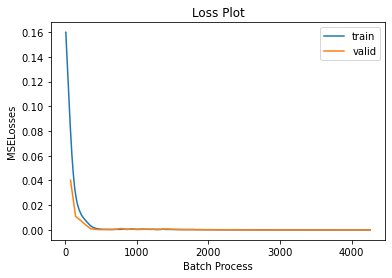

In [14]:
# 

recorder.plot_loss()
plt.title("Loss Plot")
plt.xlabel("Batch Process")
plt.ylabel("MSELosses")
#plt.savefig(os.path.join(save_dir, 'Paper architectureELU Loss Plot.png'))


In [15]:
learn.validate()

(#1) [8.321259883814491e-06]

## Plots

In [16]:
from scipy.special import inv_boxcox
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
#     df['E'] = 10**(df['E'])*1000
#     df['pt'] = 10**(df['pt'])*1000
    df['pt'] = inv_boxcox(df['pt']+mean1, maxlog1)
    df['E'] = inv_boxcox((df['E']+mean2)*10, maxlog2)
    return df

### Plot of Reconstruted input vs Orignal Input

Output of the model on the test data is obtained and then it is unnormalised.

R2 of  E 0.9996539536756623
R2 of  pt 0.9997713292427537
R2 of  eta 0.9999296111509338
R2 of  phi 0.9999798519143719


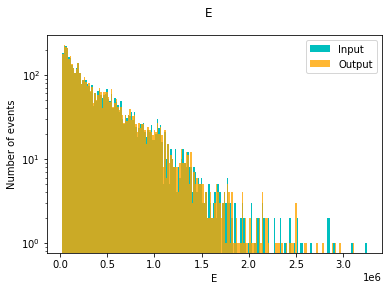

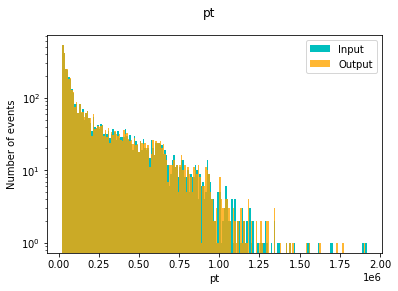

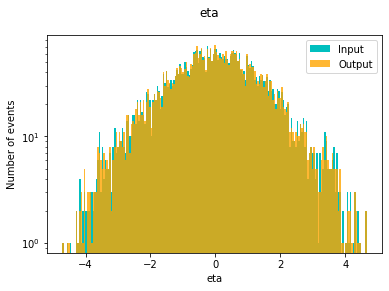

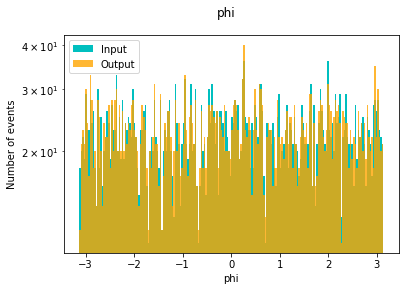

In [17]:
from sklearn.metrics import r2_score

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, len(test))  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = custom_unnormalize(pd.DataFrame(data, columns=test.columns))
pred_df = custom_unnormalize(pd.DataFrame(pred, columns=test.columns))

unnormalized_data_df = data_df
unnormalized_pred_df = pred_df    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    print("R2 of ", test.columns[kk], r2_score(unnormalized_data_df[test.columns[kk]], unnormalized_pred_df[test.columns[kk]]))
    n_hist_data, bin_edges, _ = plt.hist(unnormalized_data_df[test.columns[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(unnormalized_pred_df[test.columns[kk]], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'__NormalisedData_TanhNoInit.png'))
    plt.legend()

### Plot of Residuals

-8.087223e-06


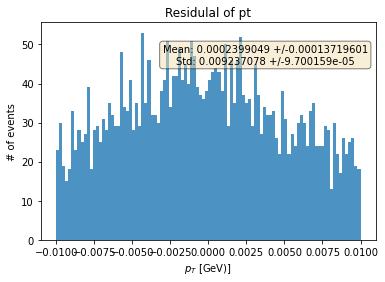

0.02828321


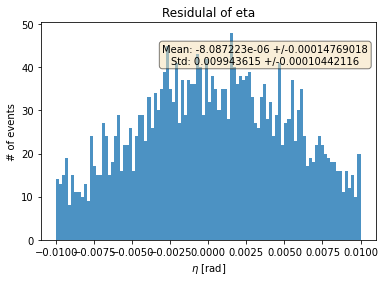

-0.00038096835


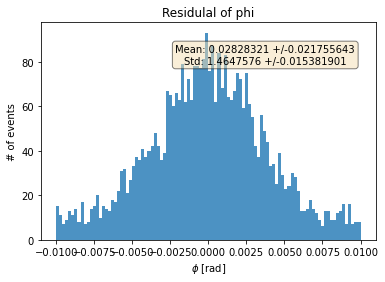

0.0002399049


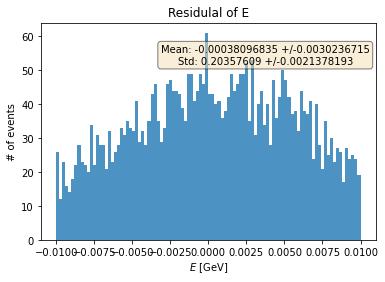

In [18]:
from scipy import stats

def find_diff(pred, data):
    diff = (pred-data)
    for i in test.columns:
        diff[i] = diff[i]/data[i]
    return diff

diff = find_diff(unnormalized_pred_df, unnormalized_data_df)
mean = diff.mean()
mean_diff = stats.sem(diff)
std = diff.std()
std_error = diff.std(ddof=0) / np.sqrt(2*len(diff))

unit_list = ['[GeV)]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

branches=["pt","eta","phi","E"]

n_bins = 100

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for kk in range(0,4):
    _, ax = plt.subplots()
    print(mean[branches[kk]])
    n_hist_data, bin_edges, _ = plt.hist(diff[branches[kk]], label='Input', alpha=0.8, bins=100, range=(-0.01, 0.01))
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.title('Residulal of '+ branches[kk])
    ax.text(0.67, 0.85, "Mean: "+str(mean[kk])+" +/-"+str(mean_diff[kk])+"\nStd: "+str(std[kk]) + " +/-"+str(std_error[kk]), horizontalalignment='center',
      verticalalignment='center', transform=ax.transAxes, bbox=props)
    plt.savefig(os.path.join(save_dir,"Resuidal of "+branches[kk]+'__NormalisedData_TanhNoInit.png'))
    plt.show()

In [19]:
diff.head()

,E,pt,eta,phi
0,-0.015937,0.000917,0.001692,0.008187
1,-0.000131,-0.007333,-0.023196,-0.041458
2,0.008010,-0.005799,0.000509,0.003309
3,-0.001046,0.007820,-0.617930,-0.007755
4,0.007651,-0.007747,0.156121,0.003266


## Corelation of Residuals

<AxesSubplot:>

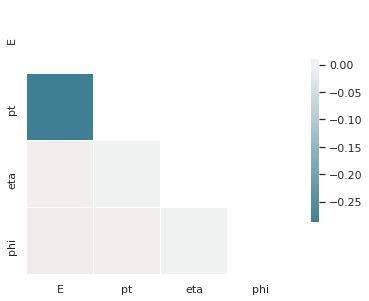

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = diff.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
from corner import corner
latent_dim = 20
save = True

corner_groups = [
    ['pt', 'eta', 'phi', 'E']
]

for i_group, group in enumerate(corner_groups):
    group_df = residuals[group]
    
    # Compute correlations
    corr = group_df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    # Plot heatmap
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.subplots_adjust(left=.23, bottom=.30, top=.99, right=.99)

    label_kwargs = {'fontsize': 20, 'rotation': -15, 'ha': 'left'}
    title_kwargs = {"fontsize": 8}
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    group_arr = group_df.values
    qs = np.quantile(group_arr, q=[.0025, .9925], axis=0)
    ndim = qs.shape[1]

    ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]

    ranges = [(-0.2, 0.2)]*ndim #Fixed-range
    figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                    bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                    show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                    levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

    # # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    linecol = 'r'
    linstyl = 'dashed'

    for xi in range(ndim):
        ax = axes[0, xi]
        # Set xlabel coords
        ax.xaxis.set_label_coords(.5, -.8)
    for yi in range(ndim):
        ax = axes[yi, 0]
        # Set ylabel coords
        ax.yaxis.set_label_coords(-.4, .5)
        ax.set_ylabel(ax.get_ylabel(), rotation=80, ha='right')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            # Set face color according to correlation
            ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
    cax = figure.add_axes([.87, .4, .04, 0.55])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation', fontsize=20)

    if i_group == 6:
        plt.subplots_adjust(left=0.13, bottom=0.21, right=.82)
    else:
        plt.subplots_adjust(left=0.13, bottom=0.20, right=.83)
    if save:
        fig_name = 'slide_corner_%d_group%d' % (20, i_group)
        plt.savefig(os.path.join(save_dir, fig_name))

if not save:
    plt.show()

NameError: name 'residuals' is not defined